In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


In [2]:
# Load data
df = pd.read_csv("Coursera.csv")

# Preprocess data
df['Course Rating'] = pd.to_numeric(df['Course Rating'], errors='coerce')
df.dropna(subset=['Course Rating'], inplace=True)
df['Content'] = df['Course Description'] + " " + df['Skills']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3440 entries, 0 to 3521
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Course Name         3440 non-null   object 
 1   University          3440 non-null   object 
 2   Difficulty Level    3440 non-null   object 
 3   Course Rating       3440 non-null   float64
 4   Course URL          3440 non-null   object 
 5   Course Description  3440 non-null   object 
 6   Skills              3440 non-null   object 
 7   Content             3440 non-null   object 
dtypes: float64(1), object(7)
memory usage: 241.9+ KB


In [4]:
df.isnull().sum()

Course Name           0
University            0
Difficulty Level      0
Course Rating         0
Course URL            0
Course Description    0
Skills                0
Content               0
dtype: int64

In [5]:
df.duplicated().sum()

98

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df['Difficulty Level'].value_counts()

Difficulty Level
Beginner          1387
Advanced           955
Intermediate       809
Conversant         143
Not Calibrated      48
Name: count, dtype: int64

In [9]:
df = df[df['Difficulty Level'] != 'Not Calibrated']

In [10]:
df['Difficulty Level'].value_counts()

Difficulty Level
Beginner        1387
Advanced         955
Intermediate     809
Conversant       143
Name: count, dtype: int64

In [11]:
df['Course Rating'].value_counts()

Course Rating
4.7    696
4.6    588
4.8    579
4.5    377
4.4    231
4.9    172
4.3    153
4.2    119
5.0     89
4.1     85
4.0     49
3.8     24
3.9     20
3.7     18
3.6     18
3.5     17
3.4     13
3.0     12
3.2      9
3.3      6
2.9      6
2.6      2
2.8      2
2.4      2
1.0      2
2.0      1
3.1      1
2.5      1
1.9      1
2.3      1
Name: count, dtype: int64

In [12]:
df['Category'] = df['Course Description'].apply(lambda x: 'Film and Cinema Studies' if any(keyword in x.lower() for keyword in ['film', 'cinema', 'movie', 'director', 'screenplay']) else
                                                    'Stock Market Investing' if any(keyword in x.lower() for keyword in ['stock market', 'investing', 'financial market', 'trading', 'stocks']) else
                                                    'Financial Analysis' if any(keyword in x.lower() for keyword in ['financial analysis', 'financial modeling', 'financial planning']) else
                                                    'Real Estate Investment' if any(keyword in x.lower() for keyword in ['real estate', 'investment property', 'real estate finance']) else
                                                    'Cryptocurrency' if any(keyword in x.lower() for keyword in ['cryptocurrency', 'blockchain', 'bitcoin', 'ethereum']) else
                                                    'Social Media Marketing' if any(keyword in x.lower() for keyword in ['social media', 'marketing', 'digital marketing', 'social media strategy']) else
                                                    'Public Speaking' if any(keyword in x.lower() for keyword in ['public speaking', 'communication skills', 'presentation']) else
                                                    'Creative Writing' if any(keyword in x.lower() for keyword in ['creative writing', 'fiction writing', 'poetry', 'storytelling']) else
                                                    'Animation' if any(keyword in x.lower() for keyword in ['animation', 'cartooning', '3d animation', 'motion graphics']) else
                                                    'Business Analytics' if any(keyword in x.lower() for keyword in ['business analytics', 'data analysis', 'business intelligence', 'data visualization']) else
                                                    'Data Analytics' if any(keyword in x.lower() for keyword in ['data', 'sql', 'data science', 'data engineering', 'big data']) else
                                                    'ML/DL' if any(keyword in x.lower() for keyword in ['machine learning', 'deep learning', 'neural network', 'tensorflow', 'pytorch']) else
                                                    'Photography' if any(keyword in x.lower() for keyword in ['photography', 'photo editing', 'portrait photography', 'landscape photography']) else
                                                    'Astronomy' if any(keyword in x.lower() for keyword in ['astronomy', 'cosmology', 'space science', 'telescope']) else
                                                    'Philosophy' if any(keyword in x.lower() for keyword in ['philosophy', 'philosophical thought', 'ethical philosophy']) else
                                                    'Game Development' if any(keyword in x.lower() for keyword in ['game development', 'game design', 'video game programming']) else
                                                    '3D Modeling' if any(keyword in x.lower() for keyword in ['3d modeling', '3d design', '3d animation']) else
                                                    'Culinary Arts' if any(keyword in x.lower() for keyword in ['culinary arts', 'cooking techniques', 'baking']) else
                                                    'Political Science' if any(keyword in x.lower() for keyword in ['political science', 'government', 'international relations']) else
                                                    'Linguistics' if any(keyword in x.lower() for keyword in ['linguistics', 'language studies', 'language structure']) else
                                                    'Fitness Training' if any(keyword in x.lower() for keyword in ['fitness training', 'exercise', 'personal training']) else
                                                    'Digital Marketing' if any(keyword in x.lower() for keyword in ['digital marketing', 'online marketing', 'internet advertising']) else
                                                    'Photography' if any(keyword in x.lower() for keyword in ['photography', 'photo editing', 'portrait photography', 'landscape photography']) else
                                                    'Economics' if any(keyword in x.lower() for keyword in ['economics', 'microeconomics', 'macroeconomics']) else
                                                    'History' if any(keyword in x.lower() for keyword in ['history', 'historical studies', 'world history']) else
                                                    'Music' if any(keyword in x.lower() for keyword in ['music', 'music theory', 'musical composition']) else
                                                    'Language Learning' if any(keyword in x.lower() for keyword in ['language learning', 'language acquisition', 'linguistic studies']) else
                                                    'Health and Wellness' if any(keyword in x.lower() for keyword in ['health', 'wellness', 'fitness']) else
                                                    'Engineering' if any(keyword in x.lower() for keyword in ['engineering', 'civil engineering', 'electrical engineering']) else
                                                    'Design' if any(keyword in x.lower() for keyword in ['design', 'graphic design', 'ux/ui design']) else
                                                    'Literature and Writing' if any(keyword in x.lower() for keyword in ['literature', 'writing', 'creative writing']) else
                                                    'Science' if any(keyword in x.lower() for keyword in ['science', 'physics', 'chemistry']) else
                                                    'Technology' if any(keyword in x.lower() for keyword in ['technology', 'computer science', 'programming']) else
                                                    'Mathematics' if any(keyword in x.lower() for keyword in ['mathematics', 'calculus', 'algebra']) else
                                                    'Language and Communication' if any(keyword in x.lower() for keyword in ['language', 'communication', 'linguistics']) else
                                                    'Other' if any(keyword in x.lower() for keyword in ['other', 'miscellaneous', 'varied', 'diverse', 'assorted', 'various', 'general']) else 'Other')


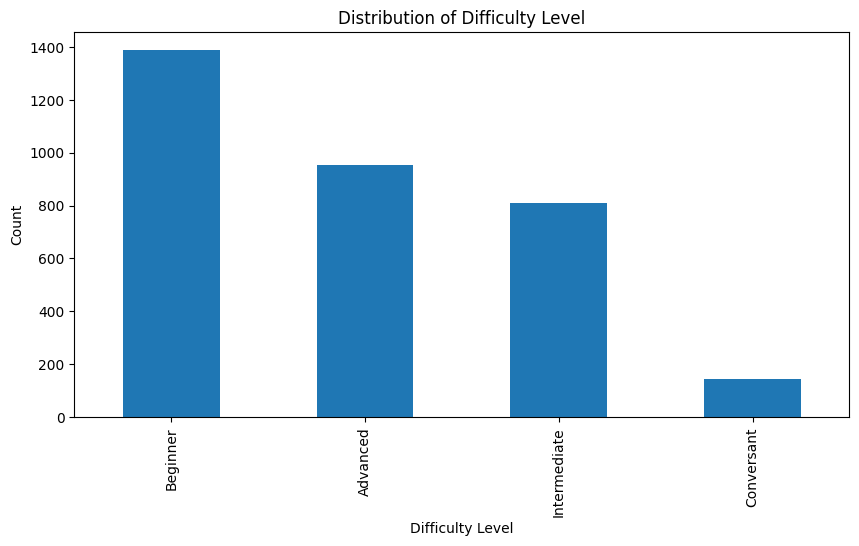

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('Distribution of Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Count')
df['Difficulty Level'].value_counts().plot(kind='bar')
plt.show()

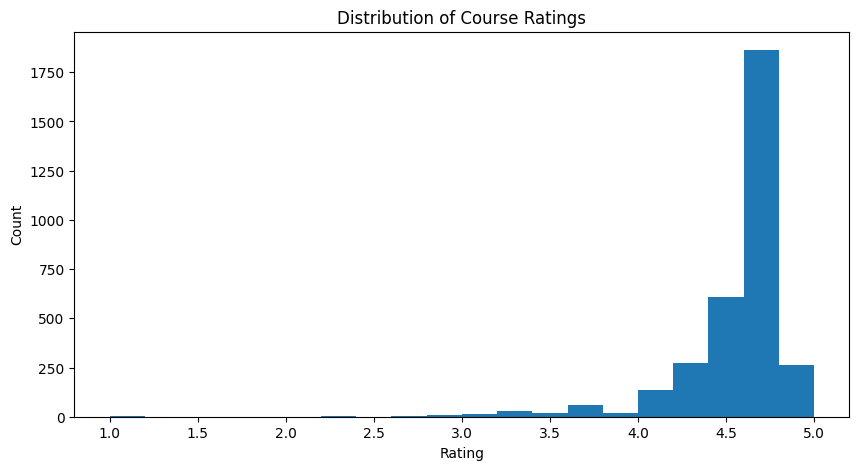

In [14]:
plt.figure(figsize=(10,5))
plt.hist(df['Course Rating'],bins=20)
plt.title('Distribution of Course Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [15]:
# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Content'])

# Dimensionality Reduction
svd = TruncatedSVD(n_components=50)
course_features = svd.fit_transform(tfidf_matrix)


In [16]:
# Simulate user preferences based on ratings
df['User Preference'] = df['Course Rating'] >= 4.5  # Assuming users prefer courses with ratings >= 4.5


In [17]:
X_train, X_test, y_train, y_test = train_test_split(course_features, df['User Preference'], test_size=0.2, random_state=42)


In [18]:
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)


LogisticRegression()

In [19]:
ensemble = VotingClassifier(estimators=[
    ('rf', model1), 
    ('lr', model2)],
    voting='soft')

ensemble.fit(X_train, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr', LogisticRegression())],
                 voting='soft')

In [20]:
predictions = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, predictions))

Ensemble Accuracy: 0.7541729893778453


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv("Coursera.csv")

# Preprocess data
df['Course Rating'] = pd.to_numeric(df['Course Rating'], errors='coerce')
df.dropna(subset=['Course Rating'], inplace=True)
df['Content'] = df['Course Description'] + " " + df['Skills']

# Simulate user preferences based on ratings
df['User Preference'] = df['Course Rating'] >= 4.5  # Assuming users prefer courses with ratings >= 4.5

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Content'])

# Dimensionality Reduction
svd = TruncatedSVD(n_components=50)
course_features = svd.fit_transform(tfidf_matrix)

# Stratified Sampling in Train-Test Split
# Using 'Difficulty Level' as the stratification criterion
X_train, X_test, y_train, y_test = train_test_split(course_features, df['User Preference'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df['Difficulty Level'])

# Define and Train Individual Models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# Ensemble Model
ensemble = VotingClassifier(estimators=[
    ('rf', model1), 
    ('lr', model2)],
    voting='soft')

ensemble.fit(X_train, y_train)

# Evaluate the Ensemble Model
predictions = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, predictions))


Ensemble Accuracy: 0.7718023255813954


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_courses(input_description='data science', num_recommendations=5):
    # Preprocess the input description
    input_tfidf = tfidf_vectorizer.transform([input_description])
    input_reduced = svd.transform(input_tfidf)  # Apply dimensionality reduction

    # Compute cosine similarity between input and all course descriptions
    similarity_scores = cosine_similarity(input_reduced, course_features)

    # Get indices of courses sorted by similarity scores
    sorted_indices = similarity_scores.argsort()[0][::-1]

    # Create a new DataFrame with the relevant columns
    recommended_courses = pd.DataFrame({'Course Name': df['Course Name'].iloc[sorted_indices[:num_recommendations]], 
                                        'University': df['University'].iloc[sorted_indices[:num_recommendations]], 
                                        'Course URL': df['Course URL'].iloc[sorted_indices[:num_recommendations]],
                                        'Course Rating': df['Course Rating'].iloc[sorted_indices[:num_recommendations]],})

    return recommended_courses


In [29]:
user_input = input("Enter a course description: ")
recommended_courses=recommend_courses(user_input,num_recommendations=10)
recommended_courses.head()

,Course Name,University,Course URL,Course Rating
3158,Music for Wellness,Berklee College of Music,https://www.coursera.org/learn/music-for-wellness,4.6
3514,The Importance and Power of Music in our Society,Universiteit Leiden,https://www.coursera.org/learn/importance-powe...,4.6
1488,Getting Started With Music Theory,Michigan State University,https://www.coursera.org/learn/music-theory,4.1
2849,Music's Big Bang: The Genesis of Rock 'n' Roll,University of Florida,https://www.coursera.org/learn/rock-and-roll-m...,4.7
2551,Fundamentals of Rehearsing Music Ensembles,The University of North Carolina at Chapel Hill,https://www.coursera.org/learn/music-ensembles,4.8
